# Retrieved data EDA

In [1]:
import rasterio
import rasterio.mask
import json
import os
import fiona 
import folium


import matplotlib.pyplot as plt 
import geopandas as gpd
import pandas as pd
import numpy as np
import ipywidgets as widgets
import rasterio as rio

import matplotlib.pyplot as plt

from ipywidgets import interact
from rasterstats import zonal_stats 
from rasterio.plot import show, show_hist

In [2]:
index = {'NDBI': 1, 
         'NDBaI': 2,	
         'MNDWI': 3,	
         'NDWI': 4,	
         'NDVI': 5,	
         'EVI': 6,	
         'SAVI': 7, 
         'population_count': 8, 
         'LST': 9}

In [3]:
# let's code colormaps for each index

cmaps = {'NDBI': 'RdYlBu',
         'NDBaI': 'RdYlBu',
         'MNDWI': 'RdYlBu',
         'NDWI': 'RdYlBu',
         'NDVI': plt.cm.summer,
         'EVI': plt.cm.summer,
         'SAVI': plt.cm.summer,
         'population_count': 'viridis',
         'LST': 'plasma'}

In [4]:
sofia_shapefile_path = './shapefiles/sofia.geojson'

In [5]:
gdf = gpd.read_file(sofia_shapefile_path)

In [11]:
# plot = gdf.plot('id')

In [6]:
winter_path = "./data/images/LC08_184030_20190217.tif"
summer_path = "./data/images/LC08_184030_20190812.tif"

In [7]:
winter = rasterio.open(winter_path)
summer = rasterio.open(summer_path)

In [8]:
winter.crs

CRS.from_epsg(32634)

In [20]:
gdf.to_crs(winter.crs, inplace=True)

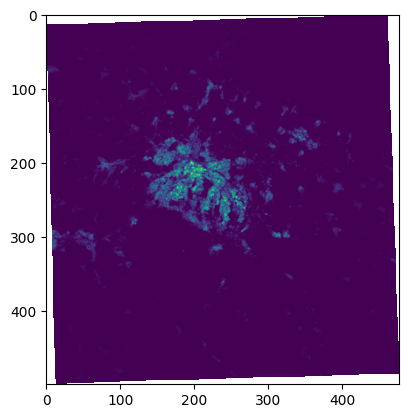

<Axes: >

In [23]:
show(winter.read(index['population_count']), cmap='viridis')

In [10]:
with open('data/id_list.json', 'r') as f:
  id_list = json.load(f)

print(type(id_list))

<class 'list'>


In [39]:
# id_list

In [11]:
def plot_single_image(image, title, cmap, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    show(image, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    plt.colorbar(ax.images[0], ax=ax, label=title)
    plt.show()

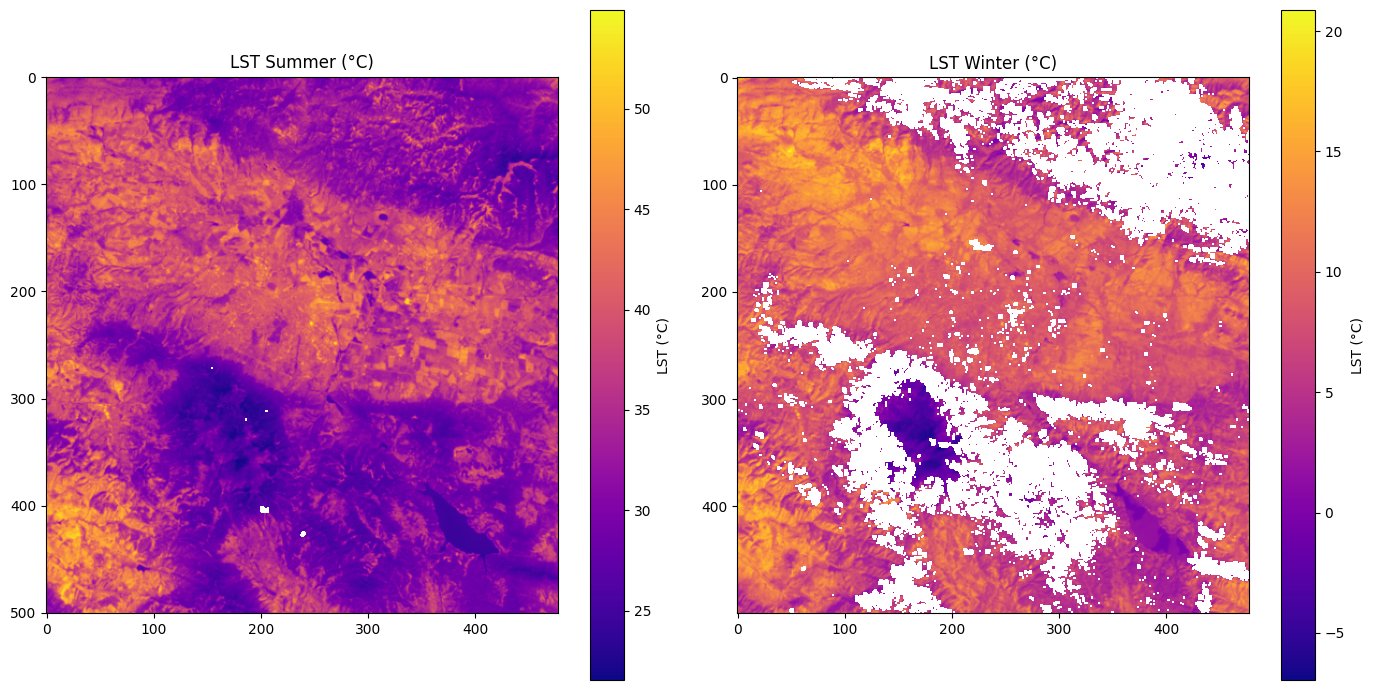

In [19]:
import matplotlib.pyplot as plt
from rasterio.plot import show

# vmin = 20
# vmax = 40

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

show(summer.read(index['LST']), ax=ax1, cmap='plasma')
ax1.set_title('LST Summer (°C)')
plt.colorbar(ax1.images[0], ax=ax1, label='LST (°C)')


show(winter.read(index['LST']), ax=ax2, cmap='plasma')
ax2.set_title('LST Winter (°C)')
plt.colorbar(ax2.images[0], ax=ax2, label='LST (°C)')


plt.tight_layout()
plt.show()


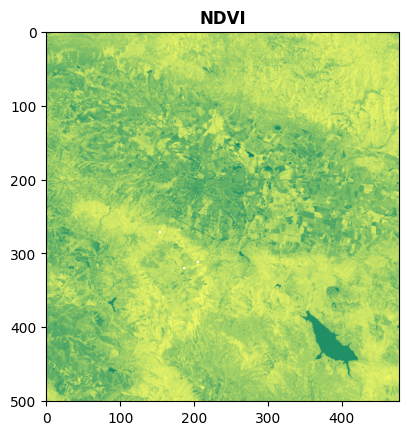

<Axes: title={'center': 'NDVI'}>

In [14]:
show(summer.read(index['NDVI']),  title="NDVI", cmap='summer')

In [15]:
# show(summer.read(index['NDBI']),  vmin=-1, vmax=1, title="NDBI", cmap='Reds')
# show(summer.read(index['NDWI']),  vmin=-1, vmax=1, title="NDWI", cmap='Blues')

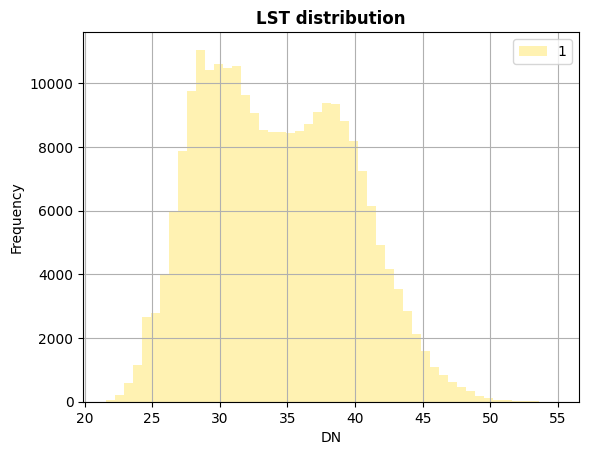

In [16]:
show_hist(summer.read(index['LST']), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="LST distribution")

## Zooming in 
Now let's focus more on the area of interest - Sofia municipality   
 
* **Clipping** 
    * First we need to make sure that the raster and vector files have **the same coordinate reference systems**. For this purpose, we use `geopandas`

    * for defining the shapes we use `fiona`

In [17]:
gdf.head()

,id,nomer,geometry
0,1,26,"MULTIPOLYGON (((23.28168 42.89617, 23.28176 42..."


In [18]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
gdf.to_crs(winter.crs, inplace=True)
gdf.crs

<Projected CRS: EPSG:32634>
Name: WGS 84 / UTM zone 34N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
summer.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 478,
 'height': 501,
 'count': 9,
 'crs': CRS.from_epsg(32634),
 'transform': Affine(120.0, 0.0, 665805.0,
        0.0, -120.0, 4755495.0)}

In [23]:
dict_of_stats = {}
dict_of_pop_stats = {}

In [38]:
for image in id_list:
    temp = rasterio.open(f"data/clipped/{image['id']}.tif")
    stats = zonal_stats(gdf, temp.read(index['LST']), stats=['mean', 'std', 'min', 'max'], affine=temp.transform, nodata=temp.nodata, geojson_out=True)
    stats_pop = zonal_stats(gdf, temp.read(index['population_count']), stats=['mean', 'std', 'min', 'max', 'sum'], affine=temp.transform, nodata=temp.nodata, geojson_out=True)
    print(stats)
    dict_of_stats[image['id']] = [stats[0]['properties']['mean'], stats[0]['properties']['std'], stats[0]['properties']['min'], 
                                  stats[0]['properties']['max']]
    dict_of_pop_stats[image['id']] = [stats_pop[0]['properties']['mean'], stats_pop[0]['properties']['std'], 
                                      stats_pop[0]['properties']['min'], 
                                      stats_pop[0]['properties']['max'], stats_pop[0]['properties']['sum']]

In [25]:
lst_stats = pd.DataFrame.from_dict(dict_of_stats).T

In [26]:
pop_stats = pd.DataFrame.from_dict(dict_of_pop_stats).T

In [27]:
lst_stats.columns = ['mean', 'std', 'min', 'max']
pop_stats.columns = ['mean', 'std', 'min', 'max', 'sum']

In [28]:
# lets load it from json 
lst_stats = pd.read_json('stats/lst_stats.json')

In [30]:

lst_stats['date'] = lst_stats.index.map(lambda x: x.split('_')[-1])
lst_stats['date'] = pd.to_datetime(lst_stats['date'], format='%Y%m%d')
lst_stats = lst_stats.sort_values('date')
lst_stats


,mean,std,min,max,date
LT05_184030_19990415,21.376584,6.076947,-3.319575,43.257784,1999-04-15
LE07_184030_19990930,23.800709,4.523431,11.268534,42.464803,1999-09-30
LT05_184030_20000128,-5.675374,2.864131,-16.496042,7.744556,2000-01-28
LE07_184030_20000527,31.675817,6.584740,13.076667,63.147242,2000-05-27
LE07_184030_20000612,30.259851,6.134779,17.540601,59.055872,2000-06-12
LE07_184030_20000628,29.195076,7.260053,11.760729,55.326812,2000-06-28
LE07_184030_20010919,0.460359,15.906680,-23.509819,41.941846,2001-09-19
LT05_184030_20050210,-8.998039,2.396483,-18.526346,6.784092,2005-02-10
LT05_184030_20060504,20.010414,5.110809,-1.422574,40.386647,2006-05-04
LT05_184030_20060520,30.101013,5.477231,3.571153,57.750188,2006-05-20


In [31]:
lst_stats.to_json('stats/lst_stats.json')

In [39]:
# raster_path = summer_path

In [32]:
def plot_zoomed_image(raster_path, title, cmap, vmin=None, vmax=None):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, gdf.geometry, crop=True, nodata=np.nan)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform}) 

    plot_single_image(out_image[index['LST'] - 1], title, 'plasma')

In [34]:
id_list.sort(key = lambda x: x['id'].split('_')[-1])

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import ipywidgets as widgets
from ipywidgets import interact


image_ids = [item['id'] for item in id_list] 


def update_map(image_id, band_name, vmin, vmax, step):
    band_index = index[band_name]
    image_path = f'data/clipped-zoomed/{image_id}.tif'
    
    with rio.open(image_path) as src:
        band = src.read(band_index)
        
        vmin = float(vmin)
        vmax = float(vmax)
        step = float(step)
        
        plt.figure(figsize=(12, 8))
        
        plt.imshow(band, cmap=cmaps[band_name])
        plt.title(f'{image_id}, Attribute: {band_name}')
        

        ticks = np.arange(vmin, vmax + step, step)
        
        plt.imshow(band, cmap=cmaps[band_name], vmin=vmin, vmax=vmax, interpolation='nearest')
        plt.colorbar(label=band_name, orientation='vertical', ticks=ticks)
        
        plt.show()


def set_scale_fields(image_id, band_name):
    band_index = index[band_name]
    image_path = f'data/clipped-zoomed/{image_id}.tif'
    
    with rio.open(image_path) as src:
        band = src.read(band_index)
        
        current_vmin = np.nanmin(band)
        current_vmax = np.nanmax(band)
    
    vmin_text.value = str(current_vmin)
    vmax_text.value = str(current_vmax)
    step_text.value = str((current_vmax - current_vmin) / 5) 

image_dropdown = widgets.Dropdown(
    options=image_ids,
    value=image_ids[0],
    description='Image:',
)

band_dropdown = widgets.Dropdown(
    options=list(index.keys()),
    value=list(index.keys())[0],
    description='Attribute:',
)


vmin_text = widgets.Text(
    description='Min scale:',
    placeholder='Enter min value',
)

vmax_text = widgets.Text(
    description='Max scale:',
    placeholder='Enter max value',
)

step_text = widgets.Text(
    description='Step size:',
    placeholder='Enter step size',
)

def update_fields(image_id, band_name):
    set_scale_fields(image_id, band_name)

interact(update_map, image_id=image_dropdown, band_name=band_dropdown, 
         vmin=vmin_text, vmax=vmax_text, step=step_text)

widgets.interactive_output(update_fields, {'image_id': image_dropdown, 'band_name': band_dropdown})


interactive(children=(Dropdown(description='Image:', options=('LE07_184030_19990930', 'LE07_184030_20010919', …

Output()